In [48]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import matplotlib.pylab as plt
from numba import jit

from functools import partial
import random

DATA_DIR = '../data/clean/'

## Import and extract data

In [2]:
bmi_by_patient = (pd.read_csv(DATA_DIR+'subset_2yrs.csv', index_col=0)
                      .dropna(axis=1, thresh=7)).T # ONLY THOSE WITH 7 OBS
bmi_by_patient.head()

MRN,472613,584276,599209,647362,689752,728998,730028,764134,794941,798124,...,40843237,40846107,40865255,40868465,40879033,40891764,95586095,96193156,96505185,96796297
0,34.613679,34.142193,26.349156,36.193387,18.796160,31.566288,22.725041,20.755906,20.302289,24.218798,...,23.331488,26.138390,20.099921,29.637929,22.594038,24.084359,25.616987,33.470148,34.853982,24.807863
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.026407,20.302289,24.205390,...,23.636893,24.515531,19.999990,30.576244,22.151273,22.838821,NaN,34.011028,NaN,26.608833
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.908206,20.901024,22.807572,...,24.348050,24.722705,19.777068,31.276793,22.764958,21.288818,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,37.272640,18.853099,NaN,23.402535,NaN,NaN,24.117025,...,24.758165,25.534134,19.753086,32.096226,23.036803,21.359046,NaN,NaN,NaN,27.426742
4,NaN,NaN,NaN,NaN,19.633149,NaN,NaN,NaN,NaN,NaN,...,25.142103,25.620457,19.678675,32.008594,23.036803,22.441817,NaN,32.062296,NaN,NaN


In [3]:
bmi_by_patient.shape

(24, 72616)

## Estimate continuous time series using interpolation

In [4]:
D, N = bmi_by_patient.shape
D, N

(24, 72616)

In [5]:
X = np.arange(D).reshape(-1, 1)

In [6]:
data_centered = bmi_by_patient - bmi_by_patient.iloc[0]
data_centered.head()

MRN,472613,584276,599209,647362,689752,728998,730028,764134,794941,798124,...,40843237,40846107,40865255,40868465,40879033,40891764,95586095,96193156,96505185,96796297
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.270502,0.000000,-0.013408,...,0.305405,-1.622859,-0.099931,0.938315,-0.442765,-1.245538,NaN,0.540880,NaN,1.800970
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.152300,0.598735,-1.411227,...,1.016562,-1.415686,-0.322853,1.638865,0.170920,-2.795541,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.079252,0.056939,NaN,0.677494,NaN,NaN,-0.101774,...,1.426678,-0.604256,-0.346835,2.458297,0.442765,-2.725313,NaN,NaN,NaN,2.618879
4,NaN,NaN,NaN,NaN,0.836989,NaN,NaN,NaN,NaN,NaN,...,1.810615,-0.517934,-0.421247,2.370665,0.442765,-1.642542,NaN,-1.407851,NaN,NaN


Remove individuals with more than a 20-point change from baseline

In [7]:
data_filtered = data_centered.T[~(data_centered.abs() > 20).sum().astype(bool)].T

In [8]:
y = data_filtered.T.values

In [9]:
from scipy.interpolate import PchipInterpolator

In [10]:
def interpolate(row, extrapolate=False):
    
    non_missing = row.dropna()
    y_interp = PchipInterpolator(non_missing.index.values.astype(int), 
                                 non_missing.values, 
                                 extrapolate=extrapolate)(row.index.values.astype(int))
    
    return pd.Series(y_interp)

In [11]:
data_interpolated = data_filtered.apply(interpolate, axis=0).fillna(method='ffill')

In [12]:
data_interpolated.shape

(24, 72496)

## Create clusters using K-means with soft-DTW distances

We will use a k-means clustering algorithm, based on dynamic time warping (DTW) as a distance metric. Unlike the Euclidean distance, DTW is able to compare asynchronous time series of varying size and is robust to elastic transformations in time. To be robust to such invariances, DTW computes a minimal cost alignment between time series using dynamic programming.

Soft-DTW is a formulation of DTW that computes the soft-minimum of all alignment costs, resulting in a differentiable loss function.

In [13]:
from tslearn.clustering import TimeSeriesKMeans

In [54]:
def run_cluster(n_clusters, data, gamma=0.1):
    from tslearn.clustering import TimeSeriesKMeans
    sdtw_km = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw", metric_params={"gamma_sdtw": gamma},
                           verbose=True, random_state=42)
    y_pred_sdtw = sdtw_km.fit_predict(data)
    return sdtw_km, y_pred_sdtw

In [55]:
results = run_cluster(48, data_interpolated.T.values, 1)

966.580 --> 935.497 --> 936.927 --> 939.041 --> 933.999 --> 935.548 --> 934.812 --> 932.996 --> 930.122 --> 928.689 --> 926.848 --> 926.285 --> 925.441 --> 925.874 --> 925.477 --> 926.004 --> 926.145 --> 926.042 --> 926.052 --> 925.542 --> 925.558 --> 926.542 --> 926.284 --> 925.875 --> 928.784 --> 927.579 --> 927.290 --> 929.255 --> 927.571 --> 927.200 --> 929.031 --> 927.344 --> 927.237 --> 927.821 --> 929.278 --> 928.152 --> 927.730 --> 928.445 --> 929.902 --> 928.518 --> 927.912 --> 928.503 --> 928.023 --> 928.683 --> 928.284 --> 928.309 --> 930.288 --> 929.271 --> 929.189 --> 930.470 --> 


In [126]:
def plot_clusters(result_set, data=data_interpolated, rows=16, cols=3, yrange=None, width=12, height=48,
                 titles=None, cluster_centers=None):
    fig, axes = plt.subplots(rows, cols)
    fig.set_figheight(height)
    fig.set_figwidth(width)
    model, y_pred = result_set
    for i,ax in enumerate(axes.ravel()):
        for xx in data.T.values[y_pred == i]:
            ax.plot(xx.ravel(), "k-", alpha=.05)
        if cluster_centers is None:
            centers = model.cluster_centers_[i].ravel()
        else:
            centers = cluster_centers[i].ravel()
        ax.plot(centers, "r-")
        if yrange:
            ax.set_ylim(*yrange)
        if titles is not None:
            ax.set_title(titles[i])
    fig.suptitle("Soft-DTW $k$-means")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

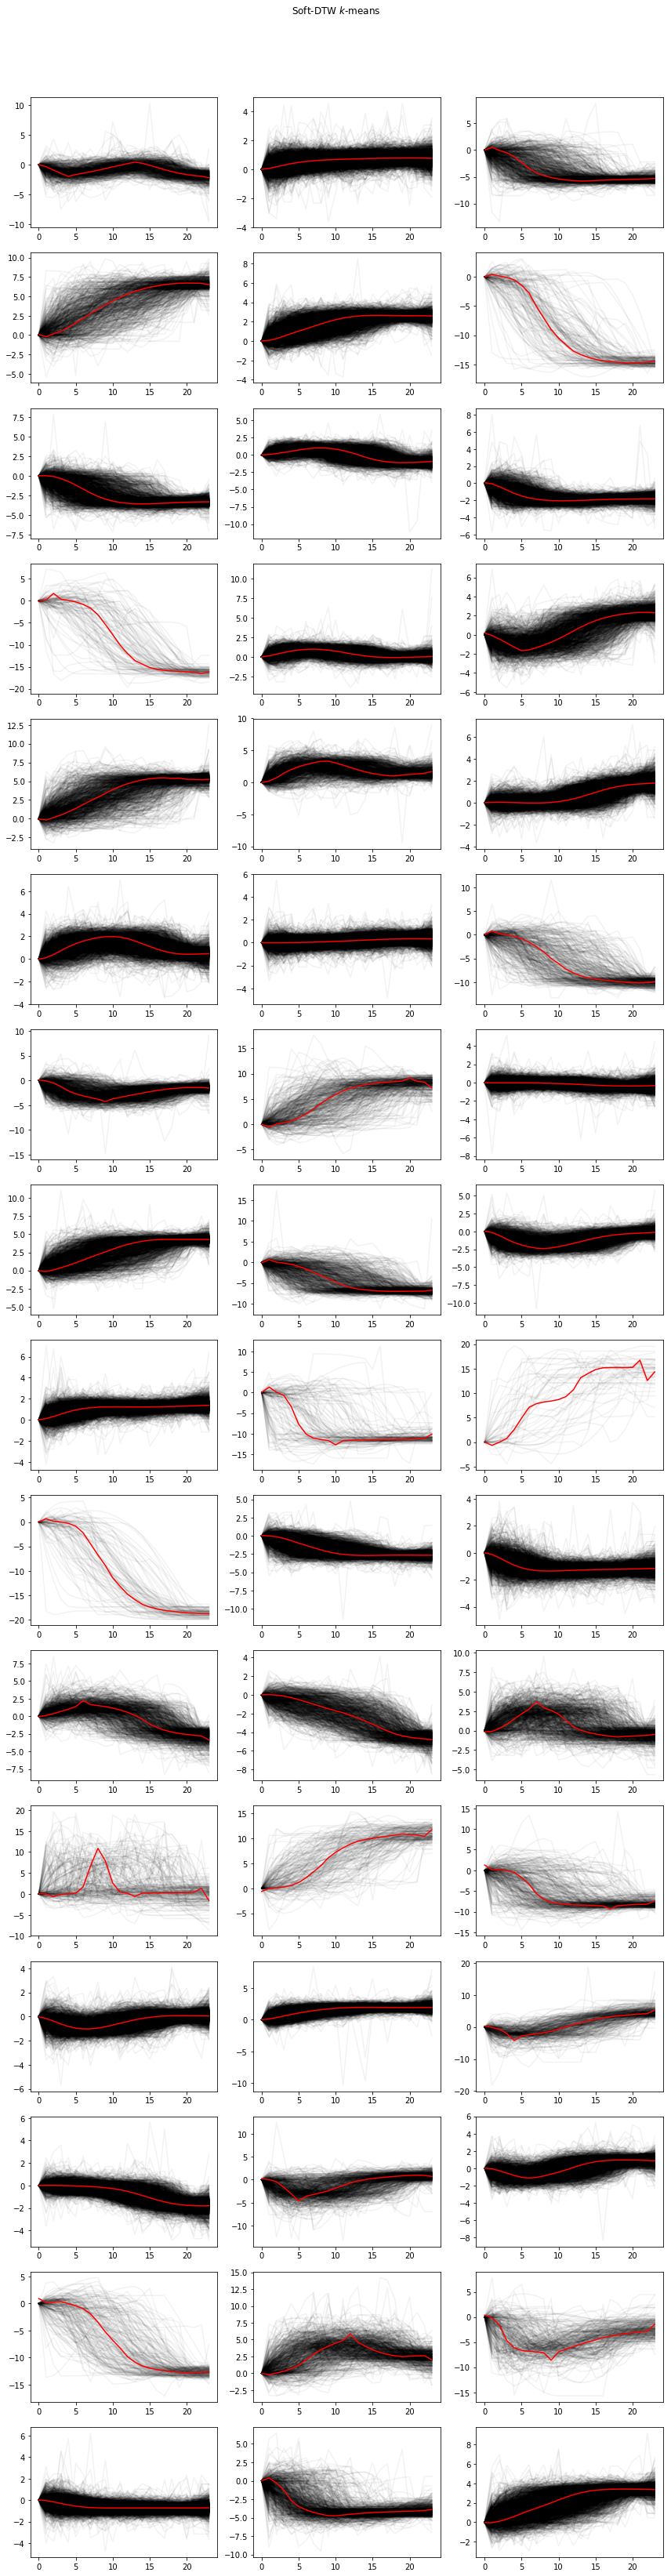

In [57]:
plot_clusters(results)

### Manual classification

In [70]:
clusters = {'flat_variable': [0, 7, 13, 15, 18, 23, 36, 41], 
            'flat': [1, 10, 16, 20, 24, 45],
           'gain_slow': [4, 12, 14, 21, 37, 38, 43, 47],
           'loss_slow': [2, 6, 8, 22, 28, 29, 30, 31, 39, 46],
           'loss_big': [5, 9, 17, 25, 27, 35, 42],
           'loss_gain': [11, 40, 44],
           'gain_big': [3, 19, 26, 34],
           'gain_loss': [32, 33]}

In [72]:
cluster_labels = ['']*48

for label in clusters:
    cluster_idx = clusters[label]
    for i in cluster_idx:
        cluster_labels[i] = label

Add clusterings to data

In [94]:
data_clustered = data_interpolated.T
data_clustered['cluster_48'] = results[1]
data_clustered['cluster_name'] = np.array(cluster_labels)[results[1]]

In [103]:
data_clustered['cluster_idx'] = data_clustered.cluster_name.replace(dict(zip(list(clusters.keys()), list(range(8)))))

In [105]:
data_clustered = data_clustered[['cluster_name', 'cluster_idx', 'cluster_48'] + list(range(24))]

In [129]:
data_clustered.head()

,cluster_name,cluster_idx,cluster_48,0,1,2,3,4,5,6,...,14,15,16,17,18,19,20,21,22,23
MRN,,,,,,,,,,,,,,,,,,,,,
472613,loss_slow,3,30,0.0,0.382034,0.703084,0.949413,1.107284,1.162961,1.111326,...,-0.841952,-1.047244,-1.254607,-1.479106,-1.735805,-2.039767,-2.432411,-2.926934,-3.496069,-4.112553
584276,gain_slow,2,14,0.0,0.106165,0.307237,0.580878,0.904750,1.256514,1.747861,...,0.149175,0.142683,0.128401,0.114119,0.107627,0.252367,0.634898,1.177688,1.803204,1.803204
599209,flat,1,10,0.0,0.007436,0.032922,0.081227,0.157119,0.265366,0.410735,...,0.363319,0.353881,0.346020,0.339610,0.334527,0.330648,0.327847,0.326001,0.324984,0.324673
647362,gain_slow,2,4,0.0,0.446080,0.845424,1.079252,1.177950,1.254301,1.313124,...,1.747861,1.901232,2.080822,2.268472,2.446029,2.595334,2.698232,2.736566,2.590609,2.299945
689752,flat,1,24,0.0,0.004973,0.022599,0.056939,0.836989,1.056744,1.188986,...,1.500701,1.500701,1.500701,1.500701,1.500701,1.500701,1.500701,1.500701,1.500701,1.500701


In [130]:
data_clustered.to_csv('data_clustered.csv')

Calculate new cluster centers

In [108]:
from tslearn.barycenters import SoftDTWBarycenter

In [117]:
new_cluster_centers = [None]*8

for k in range(8):
    new_cluster_centers[k] = SoftDTWBarycenter().fit(data_clustered.loc[data_clustered.cluster_idx==k, 
                                                                        list(range(24))].values)

Plot new clusters

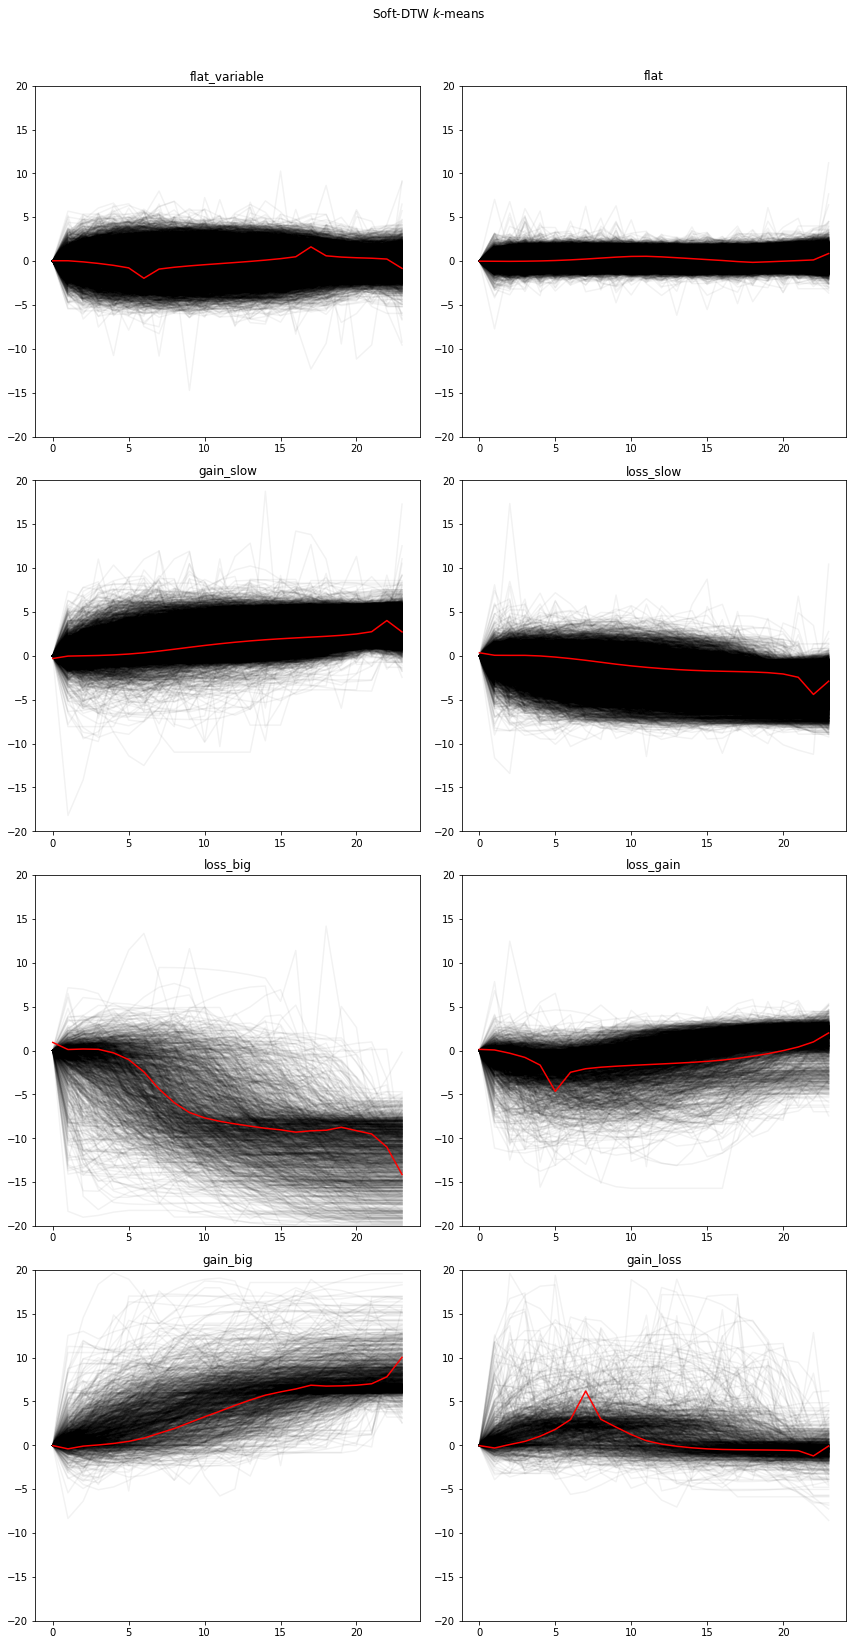

In [128]:
plot_clusters((data_clustered[list(range(24))], data_clustered.cluster_idx), rows=4, cols=2, yrange=(-20, 20),
              cluster_centers=new_cluster_centers, height=24, titles=list(clusters.keys()))

In [58]:
from scipy.cluster.hierarchy import dendrogram, linkage
from tslearn.metrics import dtw

In [60]:
cluster_centers = results[0].cluster_centers_

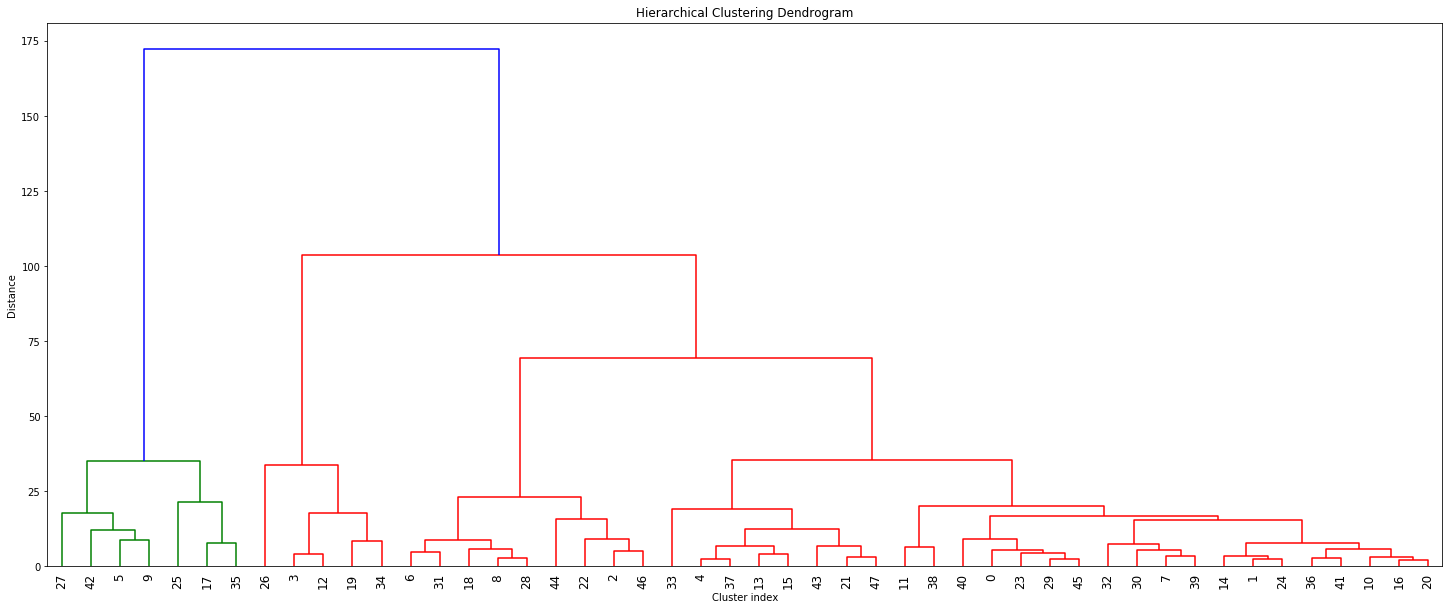

In [61]:
Z = linkage(cluster_centers.squeeze(),  method='ward')

# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster index')
plt.ylabel('Distance')
cluster_dend = dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
)